---
layout: post
title:  "Visualising Patient Contributions for the CCCC"
desc: ""
date: ###DATE
categories: [tutorial]
tags: [statistics]
loc: ###LOC
permalink: /tutorials/cccc_enrolment
math: true
---



In [1]:
import pandas as pd
import numpy as np
data = pd.read_csv("cccc_enrolment/enrolment_site.csv", parse_dates=[0], index_col=0)
data = data.fillna(0).astype(int)
data.head()

,00543-Medical University of Vienna,00544-Lancaster General Health,00546-Penn Medicine,00547-Oklahoma Heart Institute,00548-UH Cleveland Hospital,00549-Ohio State University,"00550-North Estonia Medical Centre, Tallin","00551-Tartu University Hospital, Tartu",00562-National Taiwan University Hospital,"00563-Hospital for Tropical Diseases, Vietnam",...,"510-Princess Margaret Hospital, Hong Kong","511-Queen Elizabeth Hospital, Hong Kong",514-Klinikum Passau,516-Hartford HealthCare,"517-Hospitales Puerta de Hierro, Mexico","518-Kuwait ECLS program, Al-Amiri & Jaber Al-Ahmed Hospitals",528-Hospital Universitario Virgen de Valme,"529-Severance Hospital, Seoul",534-Al-Adan Hospital,"536-Medizinische Klinik und Poliklinik II, Munich"
date_enrolment,,,,,,,,,,,,,,,,,,,,,
2019-12-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [2]:
sites = [c.split("-", 1)[1] for c in data.columns]
print(sites[:10])

['Medical University of Vienna', 'Lancaster General Health', 'Penn Medicine', 'Oklahoma Heart Institute', 'UH Cleveland Hospital', 'Ohio State University', 'North Estonia Medical Centre, Tallin', 'Tartu University Hospital, Tartu', 'National Taiwan University Hospital', 'Hospital for Tropical Diseases, Vietnam']


In [3]:
# Some of the sites are missing spaces for some reason
def fix_site(site):
    if " " not in site:
        # Dont fix a sitename which is an acryonym
        if site != site.upper():
            site = ''.join(map(lambda x: x if x.islower() else " " + x, site))   
    return site.strip()

sites_fixed = [fix_site(s) for s in sites]
print(sites_fixed[-10:])

['Princess Margaret Hospital, Hong Kong', 'Queen Elizabeth Hospital, Hong Kong', 'Klinikum Passau', 'Hartford HealthCare', 'Hospitales Puerta de Hierro, Mexico', 'Kuwait ECLS program, Al-Amiri & Jaber Al-Ahmed Hospitals', 'Hospital Universitario Virgen de Valme', 'Severance Hospital, Seoul', 'Al-Adan Hospital', 'Medizinische Klinik und Poliklinik II, Munich']


In [4]:
data_fixed = data.copy()
data_fixed.columns = sites_fixed
data_fixed

,Medical University of Vienna,Lancaster General Health,Penn Medicine,Oklahoma Heart Institute,UH Cleveland Hospital,Ohio State University,"North Estonia Medical Centre, Tallin","Tartu University Hospital, Tartu",National Taiwan University Hospital,"Hospital for Tropical Diseases, Vietnam",...,"Princess Margaret Hospital, Hong Kong","Queen Elizabeth Hospital, Hong Kong",Klinikum Passau,Hartford HealthCare,"Hospitales Puerta de Hierro, Mexico","Kuwait ECLS program, Al-Amiri & Jaber Al-Ahmed Hospitals",Hospital Universitario Virgen de Valme,"Severance Hospital, Seoul",Al-Adan Hospital,"Medizinische Klinik und Poliklinik II, Munich"
date_enrolment,,,,,,,,,,,,,,,,,,,,,
2019-12-01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2019-12-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-07-25,7,39,42,2,20,63,18,14,1,1,...,6,6,2,31,4,14,1,1,8,19
2020-07-26,7,39,42,2,20,63,18,14,1,1,...,6,6,2,31,4,14,1,1,8,19
2020-07-27,7,39,42,2,20,63,18,14,1,1,...,6,6,2,31,4,14,1,1,8,19


In [5]:
# Interpolation
fr = 30  # frame rate
t = 12  # seconds
new_index = pd.date_range("2020-02-01", data_fixed.index.max(), fr * t)

# Combine index, interp, remove original index
data_fixed = data_fixed.reindex(new_index | data_fixed.index).interpolate().loc[new_index]

In [6]:
data_fixed_change = data_fixed.diff().fillna(0)

## We need coordinates for the sites



In [7]:
from opencage.geocoder import OpenCageGeocode
key = ""
key = "37ed49b0646b443785c3f82e1d8b9a73" ###REMOVE
geocoder = OpenCageGeocode(key)

In [8]:
def get_lat_long_from_site(query):
    results = geocoder.geocode(query)
    if not len(results):
        print(f"{query} unable to be located")
        return None
    lat = results[0]['geometry']['lat']
    long = results[0]['geometry']['lng']
    country = results[0]["components"]["country"]
    return (lat, long, country)

In [10]:
import os
import json

filename = "cccc_enrolment/site_locations.json"
if not os.path.exists(filename):
    coords = {s: get_lat_long_from_site(s) for s in sites_fixed}
    # Adding the missing fields by hand, thankfully theres not that many
    coords["Uniklinik (University Hospital Frankfurt)"] = 50.0936204, 8.6506709, "Germany"
    coords["Prof Dr R. D. Kandou Central Hospital - Paediatric"] = 1.453734, 124.8056623, "Indonesia"
    coords["Kyoto Prefectural University of Medicine"] = 35.0243414, 135.7682285, "Japan"
    coords["ISMETT"] = 38.1084401, 13.3613329, "Italy"
    coords["Kuwait ECLS program, Al-Amiri & Jaber Al-Ahmed Hospitals"] = 29.3876968, 47.9881274, "Kuwait"

    # Save this out for future use to not spam the API
    with open(filename, "w") as f:
        json.dump(coords, f)
else:
    with open(filename) as f:
        coords = json.load(f)

Uniklinik (University Hospital Frankfurt) unable to be located
Kyoto Prefectural University of Medicine unable to be located
Prof Dr R. D. Kandou Central Hospital - Paediatric unable to be located
ISMETT unable to be located
Kuwait ECLS program, Al-Amiri & Jaber Al-Ahmed Hospitals unable to be located


In [11]:
def get_row(date):
    row = data_fixed.loc[date].to_frame().reset_index()
    change = data_fixed_change.loc[date].to_frame().reset_index()
    row.columns = ["site", "enrolment"]
    change.columns = ["site", "change"]
    row = row.merge(change, on="site")
    row["date"] = date
    row["coord"] = row["site"].map(coords)
    row["lat"] = row["coord"].str[0]
    row["long"] = row["coord"].str[1]
    row["country"] = row["coord"].str[2]
    row = row.drop(columns="coord")

    # Manually fix up the issues to separate HK and China
    hk = np.abs(row.lat - 22.3) < 0.2
    row.loc[hk, "country"] = "Hong Kong"
    np.random.seed(1)
    row.loc[hk, "lat"] += np.random.normal(scale=0.5, size=hk.sum())
    row.loc[hk, "long"] += np.random.normal(scale=0.5, size=hk.sum())

    
    return row

test_row = get_row(data_fixed.index.max())
test_row

,site,enrolment,change,date,lat,long,country
0,Medical University of Vienna,7.0,0.0,2020-07-29,48.208490,16.372080,Austria
1,Lancaster General Health,39.0,0.0,2020-07-29,54.016293,-2.793612,United Kingdom
2,Penn Medicine,42.0,0.0,2020-07-29,39.957043,-75.197520,United States of America
3,Oklahoma Heart Institute,2.0,0.0,2020-07-29,36.029075,-95.869532,United States of America
4,UH Cleveland Hospital,20.0,0.0,2020-07-29,41.504861,-81.605748,United States of America
...,...,...,...,...,...,...,...
115,"Kuwait ECLS program, Al-Amiri & Jaber Al-Ahmed...",14.0,0.0,2020-07-29,29.387697,47.988127,Kuwait
116,Hospital Universitario Virgen de Valme,1.0,0.0,2020-07-29,37.318825,-5.971218,Spain
117,"Severance Hospital, Seoul",1.0,0.0,2020-07-29,37.562258,126.940570,South Korea
118,Al-Adan Hospital,8.0,0.0,2020-07-29,5.258065,96.007263,Indonesia


# Basemap time

/home/samreay/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/home/samreay/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


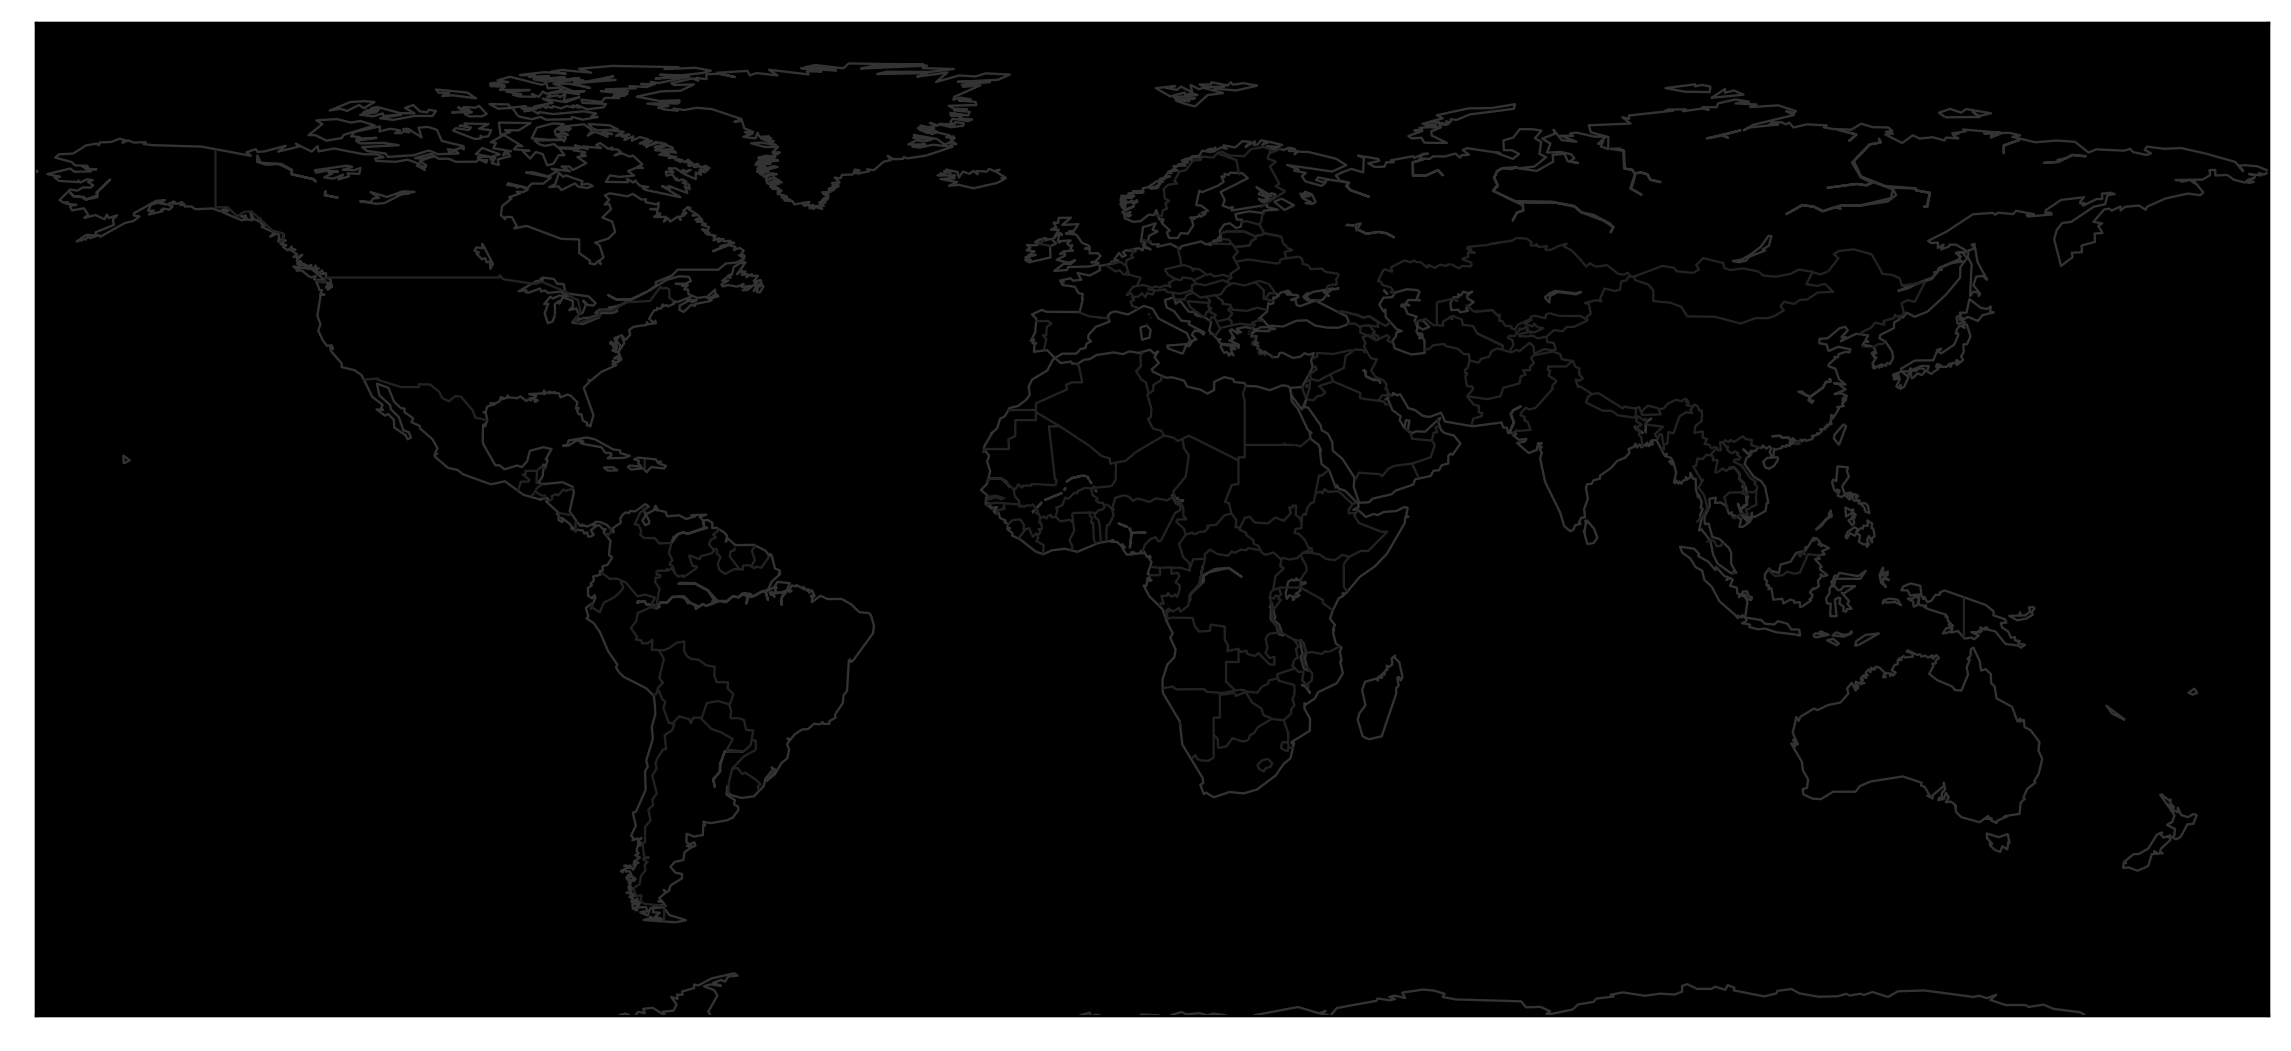

In [12]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

def get_base_fig():
    # Lets define some colors
    bg_color = "#000000"
    coast_color = "#333333"
    country_color = "#222222"
    fig = plt.figure(figsize=(12, 6))

    m = Basemap(projection='cyl', llcrnrlat=-70,urcrnrlat=90, 
                llcrnrlon=-170, urcrnrlon=190, area_thresh=10000.)
    m.fillcontinents(color=bg_color, lake_color=bg_color, zorder=-2)
    m.drawcoastlines(color=coast_color, linewidth=0.7, zorder=-1)
    m.drawcountries(color=country_color, linewidth=0.7, zorder=-1)
    m.drawmapboundary(fill_color=bg_color, zorder=-2)
    return fig, m

get_base_fig();

Great. It a pain to remove the larger rivers, involves downloading a new shape file, so we'll live with it.

# Add the dots

Let's see what it looks like if we just add some dots, with each country having a unique colour.

/home/samreay/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/home/samreay/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


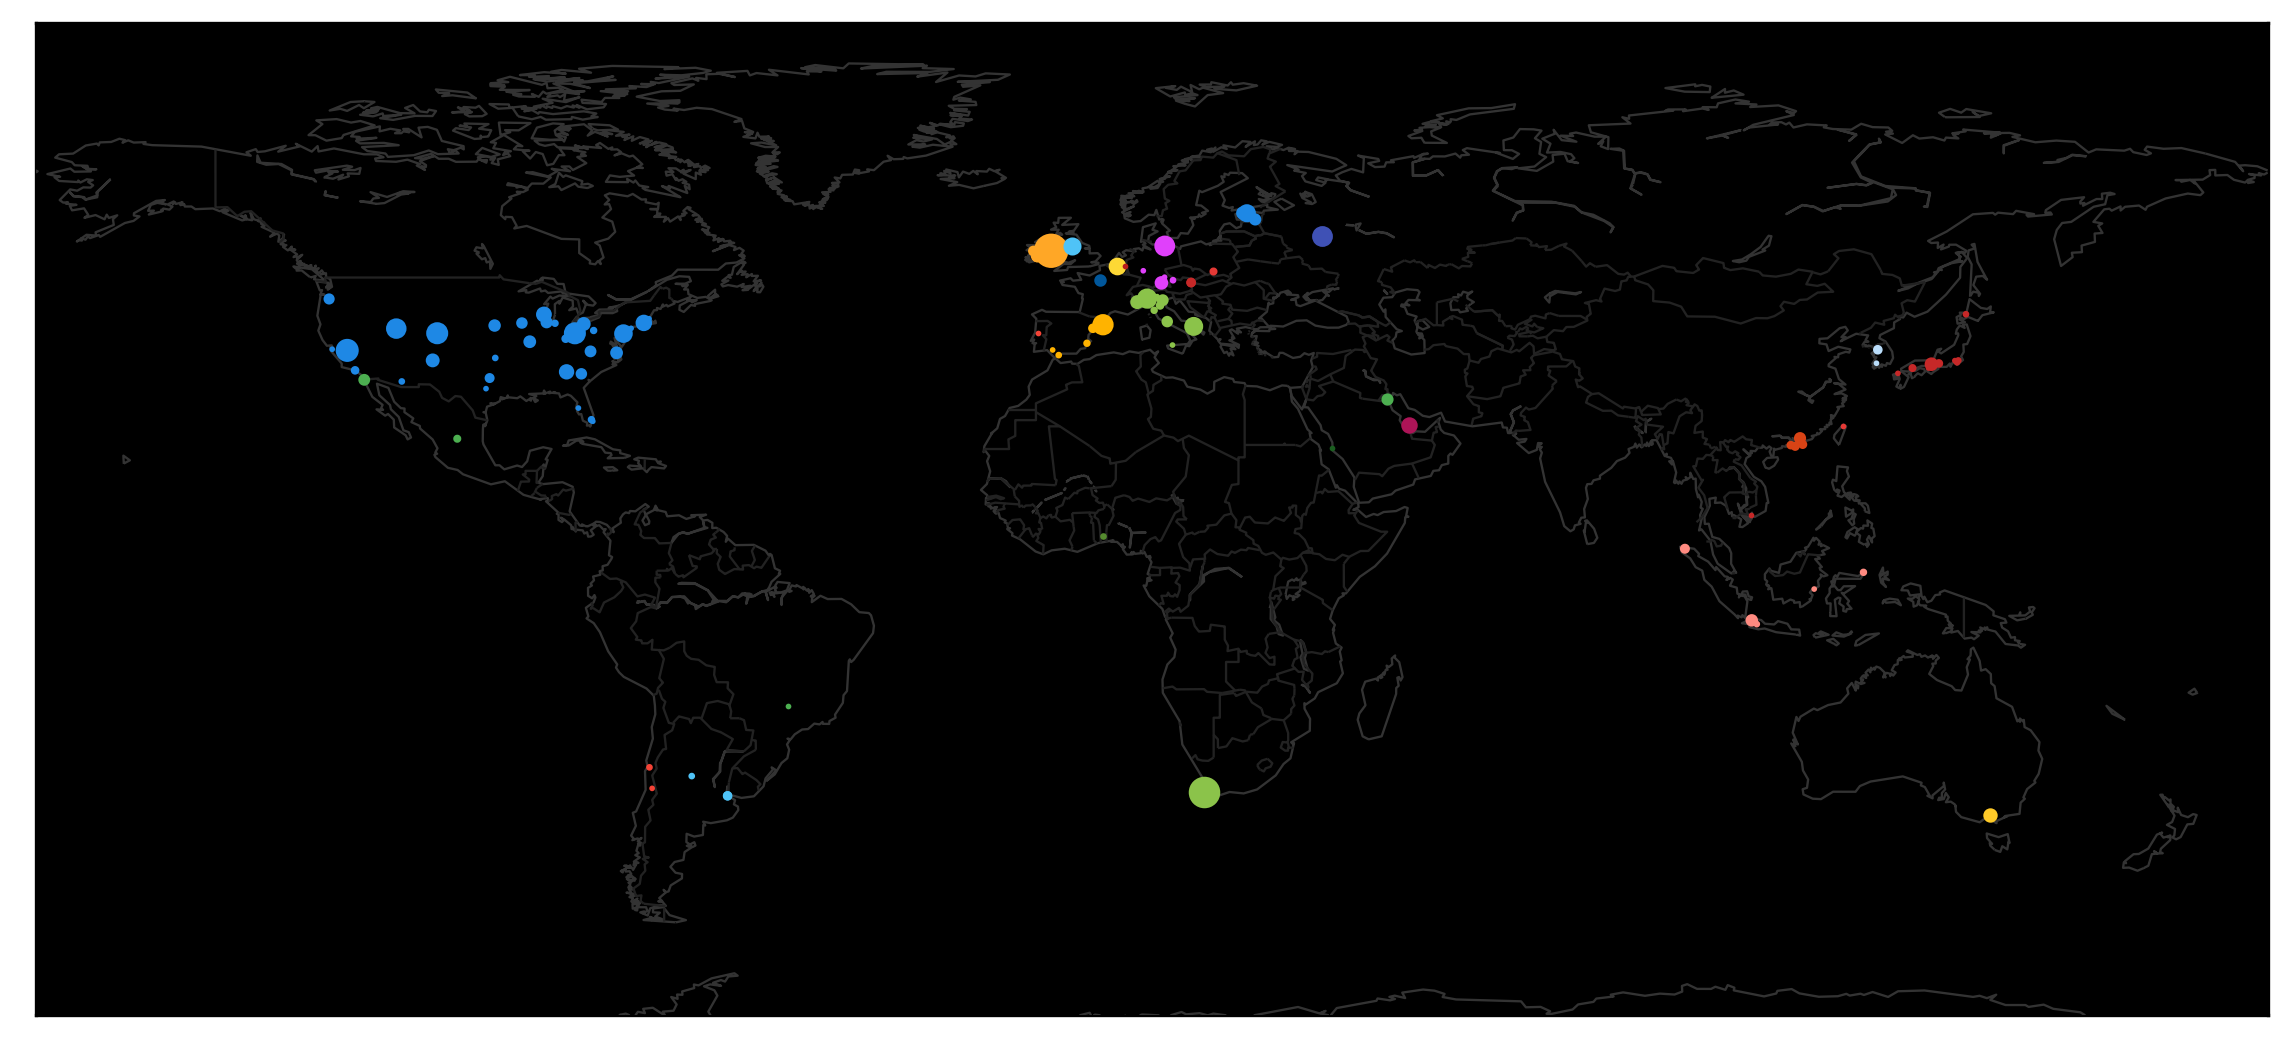

In [13]:
import numpy as np

# Colours based roughly on primary colour in countries flag
colors = {
    "Australia": "#FFD54F",
    "United States of America": "#1e88e5",
    "United Kingdom": "#4FC3F7",
    "Estonia": "#1E88E5",
    "Taiwan": "#E53935",
    "Vietnam": "#C62828",
    "Ireland": "#FFA726",
    "Brazil": "#4CAF50",
    "Argentina": "#4FC3F7",
    "Chile": "#F44336",
    "Indonesia": "#FF8A80",
    "Japan": "#C62828",
    "Germany": "#E040FB",
    "South Korea": "#BBDEFB",
    "Qatar": "#AD1457",
    "Poland": "#E53935",
    "Spain": "#FFB300",
    "Australia": "#FFCA28",
    "Russia": "#3F51B5",
    "Benin": "#558B2F",
    "Saudi Arabia": "#1B5E20",
    "Hong Kong": "#D84315",
    "France": "#01579B",
    "The Netherlands": "#B71C1C",
    "Belgium": "#FDD835",
    "Kuwait": "#4CAF50",
    "Yemen": "#D81B60",
    "Italy": "#8BC34A",
    "Austria": "#C62828",
    "Mexico": "#4CAF50",
    "Portugal": "#F44336",
    "South Africa": "#8BC34A",
}

def get_scatter(data):
    fig, m = get_base_fig()
    # Loop over each country and its institutions
    
    for country in np.unique(data.country):
        c = colors.get(country, "#FF99FF")
        subset = data.loc[(data.country == country) & (data.enrolment > 0), :]
        s = subset.enrolment * 0.5
        m.scatter(subset.long, subset.lat, latlon=True, c=c, s=s, zorder=1)
    return m

get_scatter(test_row);

I mean... it's nice. But *cool* graphics glow and have colour changing. 

/home/samreay/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/home/samreay/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


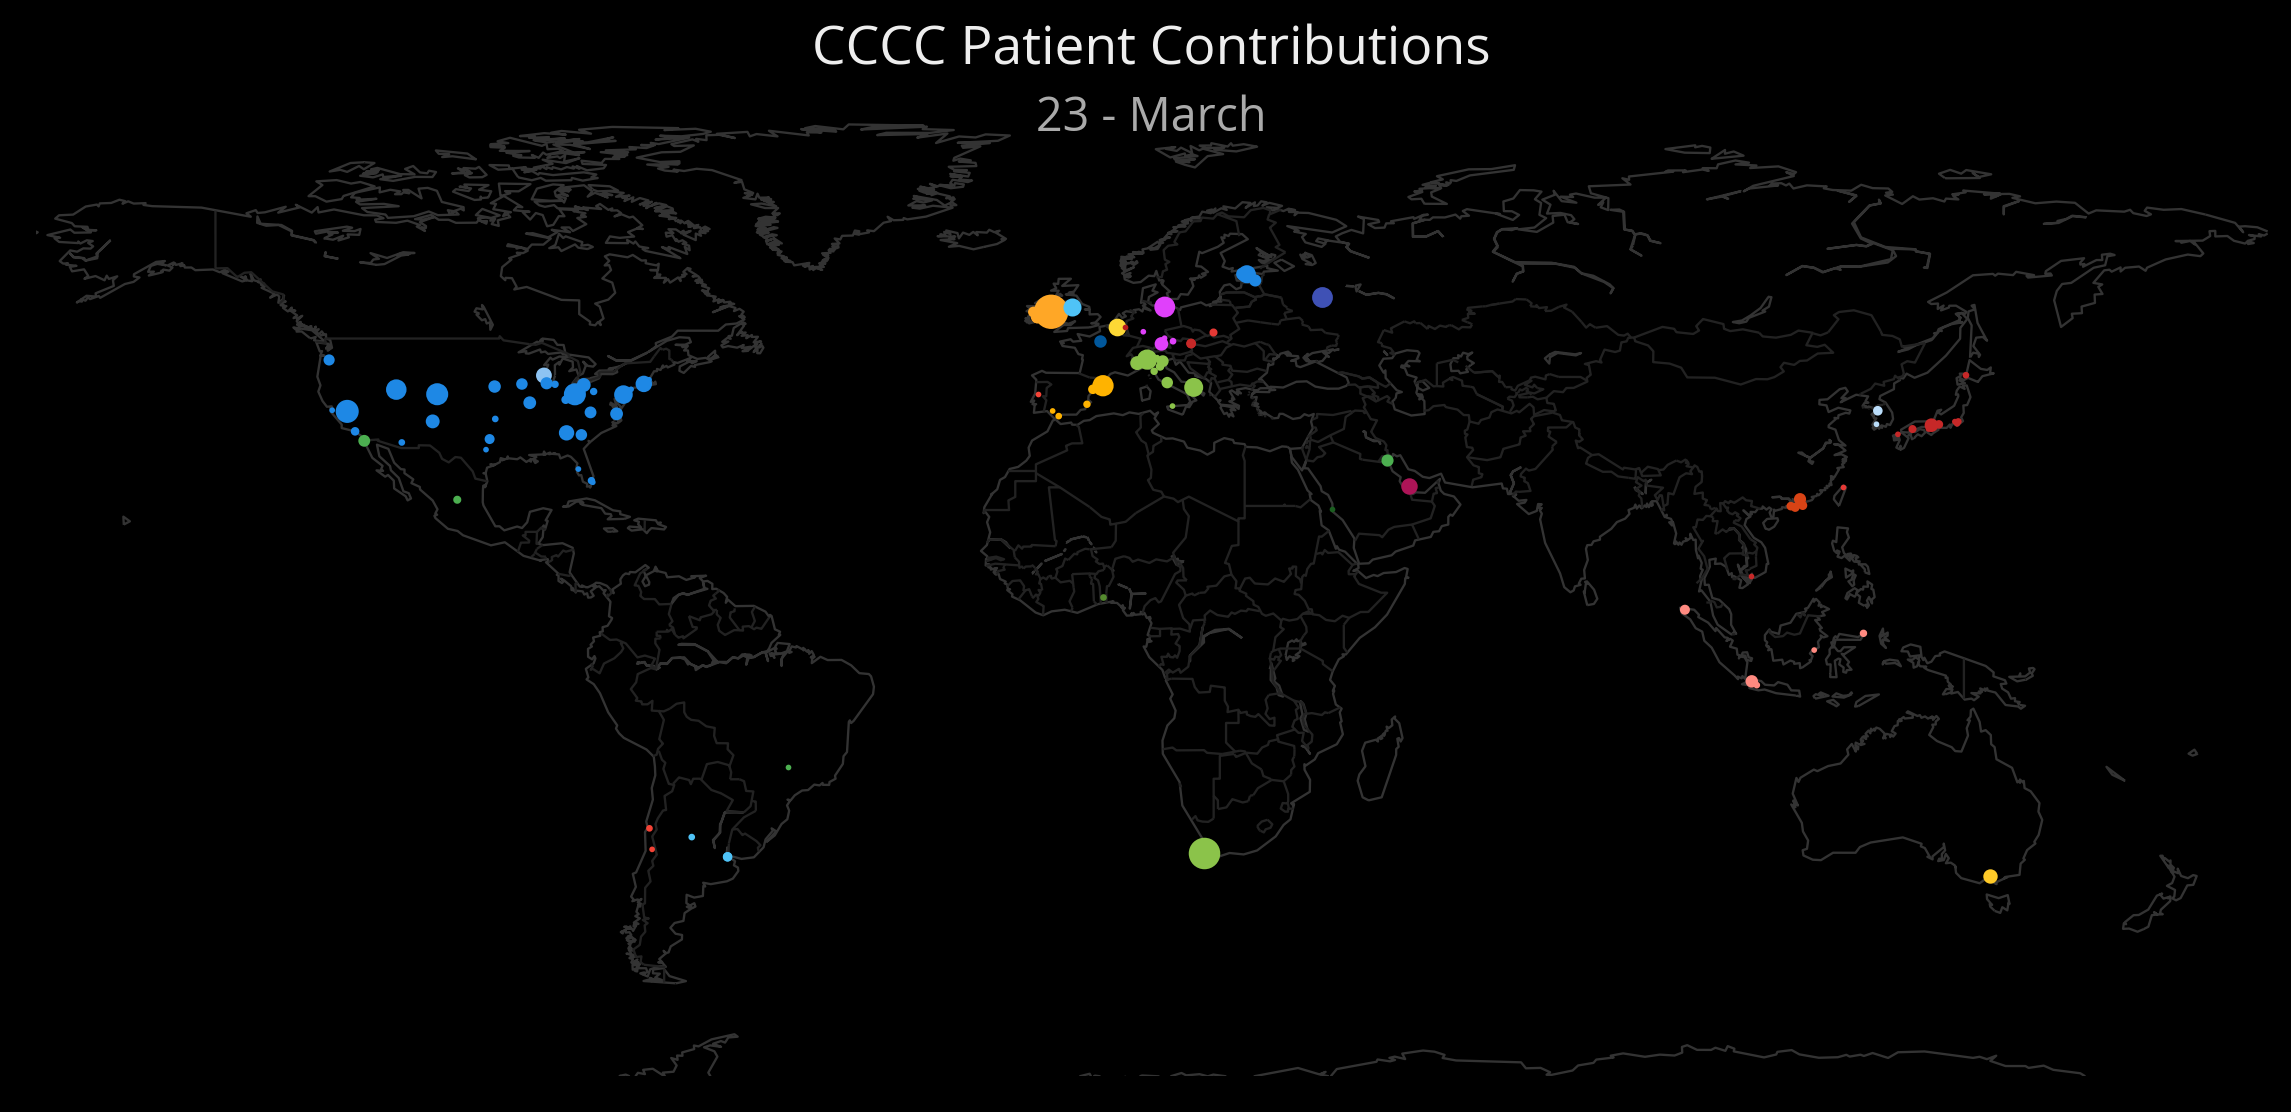

In [14]:
from matplotlib.colors import LinearSegmentedColormap as LSC

def get_shaded(data, date, frame=0, show=False):
    fig, m = get_base_fig()
    # Loop over each country and its institutions
    
    max_v = data.change.max() + 1
    
    for country in np.unique(data.country):
        c = colors.get(country)
        if c is None:
            c = "#FF99FF"
            print(f"Cannot find colour for country {country}")
        # From base colour, increase intensity of patients added today
        cmap = LSC.from_list("fade", [c, "#FFFFFF"], N=100)
        subset = data.loc[(data.country == country) & (data.enrolment > 0), :]
        s = subset.enrolment * 0.5
        cs = cmap(2 * subset.change / max_v)
        m.scatter(subset.long, subset.lat, latlon=True, c=cs, s=s, zorder=1)
        
    # Set the title, and make the background black
    plt.title("CCCC Patient Contributions", fontsize=16, color="#EEEEEE", fontname="Open Sans")
    d = pd.to_datetime(date).strftime("%d - %B")
    ax = fig.get_axes()[0]
    plt.text(0.5, 0.99, d, c="#AAAAAA", fontsize=14, 
             verticalalignment="top", horizontalalignment="center",
             transform=ax.transAxes)

    fig.patch.set_facecolor("#000000")
    if show:
        return fig
    else:
        name = f"cccc_enrolment/output/{frame:04d}.png"
        fig.savefig(name, bbox_inches="tight", padding=0, facecolor=fig.get_facecolor(), transparent=False, dpi=300)
        plt.close(fig)

get_shaded(test_row, "2020-03-23", show=True);

Great, well that's something I would call good enough for now. Of course... it would be better if it was animated. But that is definitely not something I intend to do in a notebook! In fact, I've done it already, you can see it below:

In [16]:
def plot_date(i, date):
    data = get_row(date)
    get_shaded(data, date, i)

In [17]:
from joblib import Parallel, delayed
indexes = data_fixed.index[data_fixed.index > "2020-02"]

In [18]:
for i, date in enumerate(indexes):
    plot_date(i, date)

/home/samreay/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  if sys.path[0] == '':
/home/samreay/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  from ipykernel import kernelapp as app


In [ ]:
```
ffmpeg -r 30 -i cccc_enrolment/output/%04d.png -i cccc_enrolment/mask.png -filter_complex "      [1]setsar=sar=0[p],
[0]split[a][b],
[a][p]overlay,lumakey=0:tolerance=0.3:softness=0.3[x];
color=black,format=rgb24[c];
[c][x]scale2ref[c][i];
[c][i]overlay=format=auto:shortest=1,
setsar=sar=1,
gblur=30:3,
curves=all='0/0 0.5/0.9 1/0.9'[d],
[b]setsar=sar=1[e],
[d][e]blend=all_mode=addition,
scale=1920:-2,
tpad=stop_mode=clone:stop_duration=4
" -vcodec libx264 -crf 23 -movflags faststart -pix_fmt yuv420p cccc_enrolment/contributions.mp4
```

In [20]:
from IPython.display import Video
Video("cccc_enrolment/contributions.mp4")